In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
import astropy.units as u
from astropy.coordinates import SkyCoord
from IPython.display import Image, display
import glob
import os
import sys

sys.path.insert(0, '/home/aew492/lss-dipoles/code')
import tools
import generate_mocks as gm
import dipole

#### questions
1. Under what conditions do we need to regularize / when is regularization justified?
2. What impact does "excess" power and shot noise have on the measured $C_\ell$ and measured $a_{\ell m}$?
3. Confirm that the measured $a_{\ell m}$ coefficients are unbiased, but that the measured $C_\ell$ are positively biased?

#### helper functions

In [3]:
def get_result_fns(set_name, result_type, excess_mode, selfunc_mode, dipamp, base_rate):
    dir_results = os.path.join(f'/scratch/aew492/lss-dipoles_results/results/results_mocks', set_name)
    pattern = f"{dir_results}/{result_type}*_case*{excess_mode}*{selfunc_mode}*{dipamp:.4f}*{base_rate:.3f}*.npy"
    fns_mock = glob.glob(pattern)
    # print(f"found {len(fns_mock)} files for this mock case: {pattern}")
    return fns_mock

In [4]:
def show_mock_pngs(set_name, excess_mode='', selfunc_mode='', dipamp='', base_rate='', trials='all'):
    dir_mocks = os.path.join('/scratch/aew492/lss-dipoles_results/data/mocks', set_name)
    all_fns = glob.glob(os.path.join(dir_mocks, f'*{excess_mode}*{selfunc_mode}*{dipamp}*{base_rate}*.png'))
    fns = all_fns.copy()
    if trials is not None:
        trials_str = [f'trial{trial:03d}' for trial in trials]
        for i, fn in enumerate(all_fns):
            if not any(trial_str in fn for trial_str in trials_str):
                fns.remove(fn)
    for fn in fns:
        display(Image(fn))

In [5]:
def gather_Cell_results(Lambdas, set_name, case_dict):
    Cells_res = []
    for i, Lambda in enumerate(Lambdas):
        fns = get_result_fns(set_name, f'Cells_Lambda-{Lambda:.1e}', **case_dict)
        if len(fns) == 0:
            print(f"no files found for Lambda={Lambda:.1e}")
            continue
        
        Cells = []
        for i, fn in enumerate(fns):
            res = np.load(fn, allow_pickle=True).item()
            Cells.append(res['Cells'][1:])
        ells = res['ells'][1:]
    
        res_dict = {
            'ells' : ells,
            'Cells' : Cells,
            'mean_Cells' : np.mean(np.array(Cells), axis=0),
            'std_Cells' : np.std(np.array(Cells), axis=0),
            'Lambda' : Lambda
        }
        Cells_res.append(res_dict)
    return Cells_res

In [6]:
def gather_dipole_results(set_name, case_dict):
    dipole_amps = []
    fns = get_result_fns(set_name, f'dipole_comps', **case_dict)
    for i, fn in enumerate(fns):
        res = np.load(fn, allow_pickle=True).item()
        dipole_amps.append(np.linalg.norm(res['dipole_comps'], axis=1))
    Lambdas = res['Lambdas']

    res_dict = {
        'Lambdas' : Lambdas,
        'amps' : np.array(dipole_amps),
        'mean_amp' : np.mean(np.array(dipole_amps), axis=0),
        'std_amp' : np.std(np.array(dipole_amps), axis=0),
        'input' : case_dict['dipamp']
    }
    return res_dict

#### Case 1. shot noise on the full sky

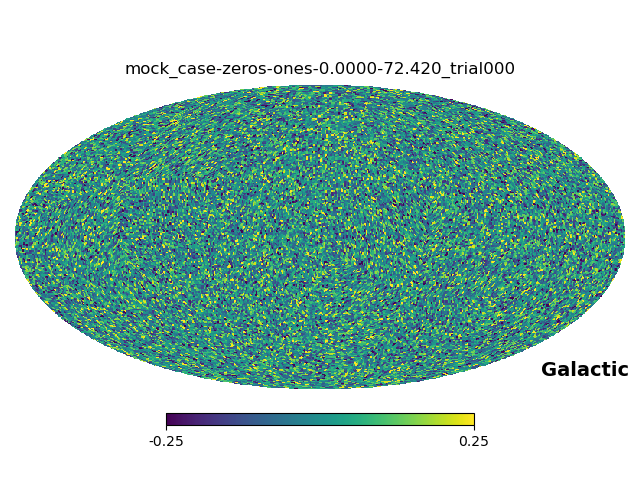

In [7]:
Lambdas = [0., 1e-3, 1e-2, 1e-1]
set_name = 'shot_noise_catwise'
case_dict = dict(excess_mode='zeros', selfunc_mode='ones', dipamp=0., base_rate=72.42)

im_fn = show_mock_pngs(set_name, trials=[0], **case_dict)

Cells_res = gather_Cell_results(Lambdas, set_name, case_dict)
dipole_res = gather_dipole_results(set_name, case_dict)

In [8]:
# ** we'll use this colormap for the rest of the notebook
norm = mpl.colors.LogNorm(vmin=min(Lambdas[1:]), vmax=max(Lambdas))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool')

Text(0.5, 1.0, 'Recovered Cells, shot_noise_catwise mocks')

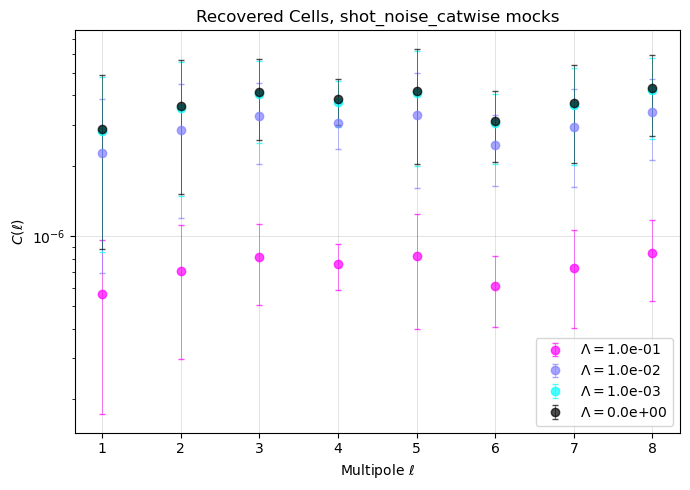

In [9]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

kwargs = dict(marker='o', ls='None', capsize=2, lw=0.5, alpha=0.7)
for res_dict in Cells_res[::-1]:
    Lambda = res_dict['Lambda']
    c = smap.to_rgba(Lambda) if Lambda != 0. else 'k'
    ax.errorbar(res_dict['ells'], res_dict['mean_Cells'], yerr=res_dict['std_Cells'], c=c,
                label='$\Lambda=$'f'{Lambda:.1e}', **kwargs)

ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel('$C(\ell)$')
ax.legend()
ax.set_title(f'Recovered Cells, {set_name} mocks')

Text(0.5, 1.0, 'Recovered dipole amplitudes, shot_noise_catwise mocks')

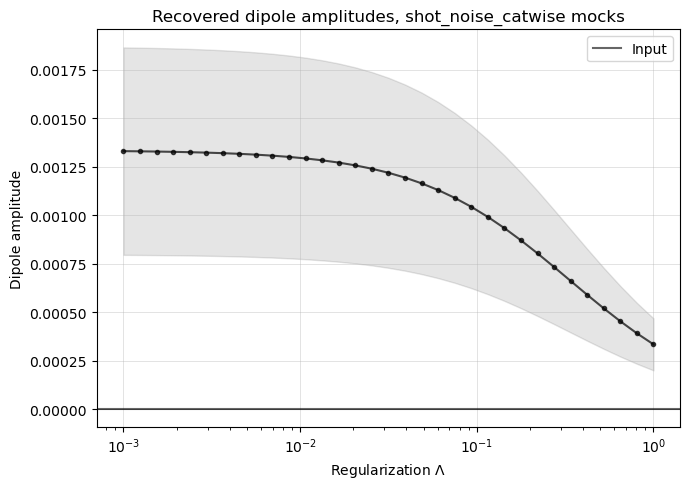

In [10]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

ax.plot(dipole_res['Lambdas'], dipole_res['mean_amp'], 'k.-', alpha=0.7)
ax.fill_between(dipole_res['Lambdas'], dipole_res['mean_amp'] - dipole_res['std_amp'], dipole_res['mean_amp'] + dipole_res['std_amp'],
                color='k', alpha=0.1)
ax.axhline(dipole_res['input'], alpha=0.6, c='k', label='Input')
ax.grid(alpha=0.5, lw=0.5)
ax.semilogx()
ax.axhline(0., c='k', lw=0.5, alpha=0.5)
ax.set_xlabel(r'Regularization $\Lambda$')
ax.set_ylabel(r'Dipole amplitude')
ax.legend()
ax.set_title(f'Recovered dipole amplitudes, {set_name} mocks')

#### Case 2. shot noise on the cut sky

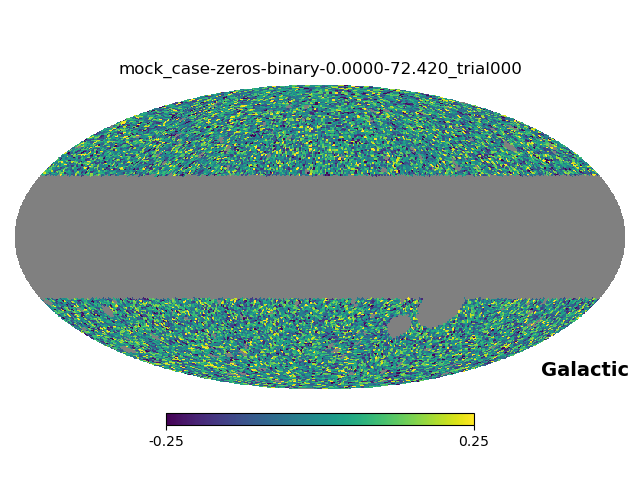

no files found for Lambda=1.0e-03
no files found for Lambda=1.0e-01


In [11]:
set_name = 'shot_noise_catwise'
case_dict = dict(excess_mode='zeros', selfunc_mode='binary', dipamp=0., base_rate=72.42)

im_fn = show_mock_pngs(set_name, trials=[0], **case_dict)

Cells_res_cutsky = gather_Cell_results(Lambdas, set_name, case_dict)
dipole_res_cutsky = gather_dipole_results(set_name, case_dict)

Text(0.5, 1.0, 'Recovered Cells, shot_noise_catwise mocks')

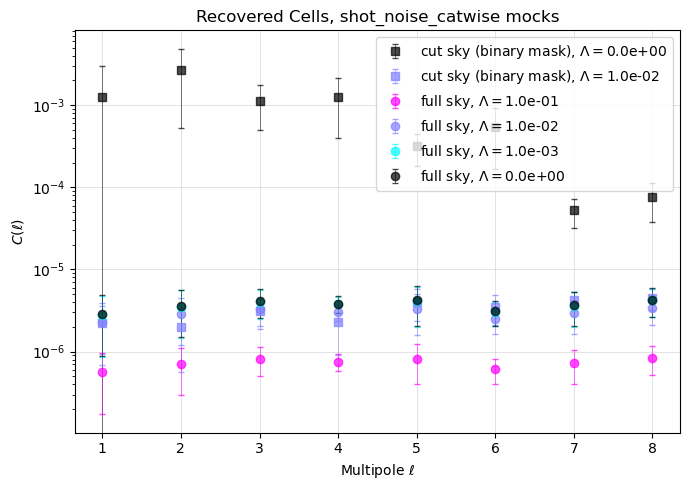

In [12]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

kwargs = dict(ls='None', capsize=2, lw=0.5, alpha=0.7)
for i, res_dict in enumerate(Cells_res_cutsky):
    Lambda = res_dict['Lambda']
    c = 'k' if Lambda == 0. else smap.to_rgba(Lambda)
    ax.errorbar(res_dict['ells'], res_dict['mean_Cells'], yerr=res_dict['std_Cells'], c=c, marker='s',
                label=r'cut sky (binary mask), $\Lambda=$'f'{Lambda:.1e}', **kwargs)
for res_dict in Cells_res[::-1]:
    Lambda = res_dict['Lambda']
    if Lambda in Lambdas:
        c = 'k' if Lambda == 0. else smap.to_rgba(Lambda)
        ax.errorbar(res_dict['ells'], res_dict['mean_Cells'], yerr=res_dict['std_Cells'], c=c, marker='o',
                label=r'full sky, $\Lambda=$'f'{Lambda:.1e}', **kwargs)

ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel('$C(\ell)$')
ax.legend()
ax.set_title(f'Recovered Cells, {set_name} mocks')

**So with shot noise, we _do_ need to regularize on the cut sky.**

This makes sense to me because we have non-zero power at all $\ell$, and with the cut sky, the $Y_{\ell m}$ are no longer orthogonal, so we see the "stairstep" effect.

Text(0.5, 1.0, 'Recovered dipole amplitudes, shot_noise_catwise mocks')

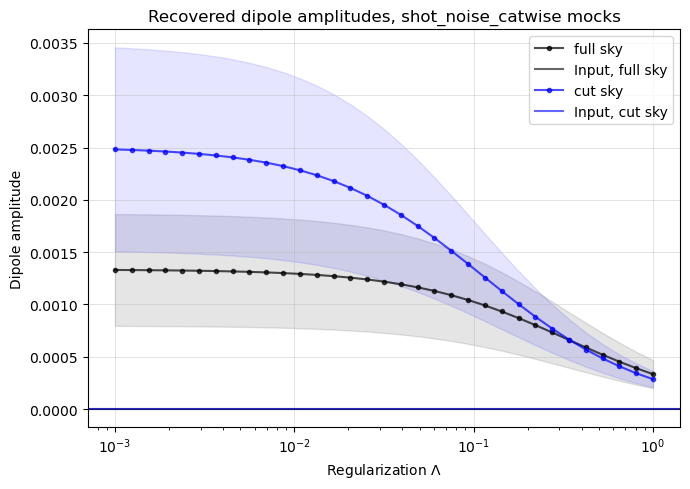

In [13]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

ax.plot(dipole_res['Lambdas'], dipole_res['mean_amp'], 'k.-', alpha=0.7, label='full sky')
ax.fill_between(dipole_res['Lambdas'], dipole_res['mean_amp'] - dipole_res['std_amp'], dipole_res['mean_amp'] + dipole_res['std_amp'],
                color='k', alpha=0.1)
ax.axhline(dipole_res['input'], alpha=0.6, c='k', label='Input, full sky')

ax.plot(dipole_res_cutsky['Lambdas'], dipole_res_cutsky['mean_amp'], 'b.-', alpha=0.7, label='cut sky')
ax.fill_between(dipole_res_cutsky['Lambdas'], dipole_res_cutsky['mean_amp'] - dipole_res_cutsky['std_amp'],
                dipole_res_cutsky['mean_amp'] + dipole_res_cutsky['std_amp'],
                color='b', alpha=0.1)
ax.axhline(dipole_res_cutsky['input'], alpha=0.6, c='b', label='Input, cut sky')

ax.grid(alpha=0.5, lw=0.5)
ax.semilogx()
ax.axhline(0., c='k', lw=0.5, alpha=0.5)
ax.set_xlabel(r'Regularization $\Lambda$')
ax.set_ylabel(r'Dipole amplitude')
ax.legend()
ax.set_title(f'Recovered dipole amplitudes, {set_name} mocks')

#### Case 3. excess power on the full sky, _no_ shot noise

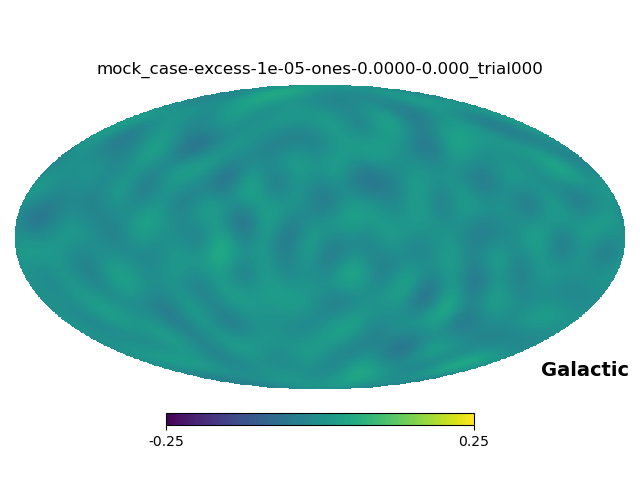

no files found for Lambda=1.0e-03
no files found for Lambda=1.0e-01


In [14]:
set_name = 'excess'
case_dict = dict(excess_mode='excess', selfunc_mode='ones', dipamp=0., base_rate=0.)

im_fn = show_mock_pngs(set_name, trials=[0], **case_dict)

Cells_res = gather_Cell_results(Lambdas, set_name, case_dict)
dipole_res = gather_dipole_results(set_name, case_dict)

Text(0.5, 1.0, 'Recovered Cells, excess mocks')

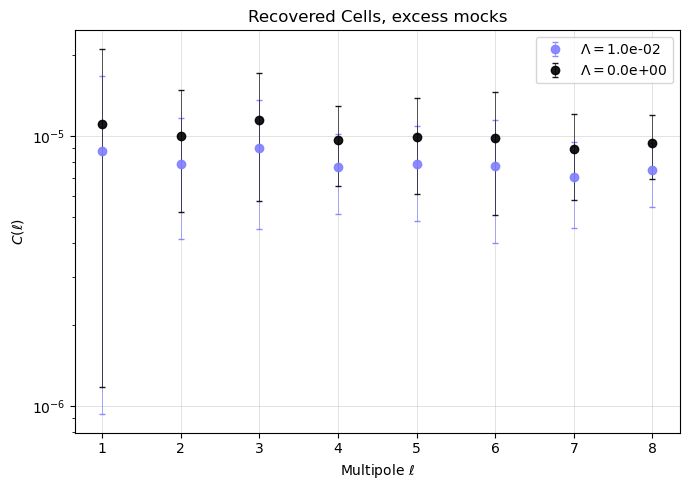

In [15]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

kwargs = dict(marker='o', ls='None', capsize=2, lw=0.5, alpha=0.9)
for res_dict in Cells_res[::-1]:
    Lambda = res_dict['Lambda']
    c = smap.to_rgba(Lambda) if Lambda != 0. else 'k'
    ax.errorbar(res_dict['ells'], res_dict['mean_Cells'], yerr=res_dict['std_Cells'], c=c,
                label='$\Lambda=$'f'{Lambda:.1e}', **kwargs)

ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel('$C(\ell)$')
ax.legend()
ax.set_title(f'Recovered Cells, {set_name} mocks')

Okay so we pretty much recover what we input, $C(\ell) = 10^{-5}$, with no regularization, and we see that any $\Lambda > 0$ will over-regularize, since we have a full sky so the $Y_{\ell m}$ are orthogonal.

#### Case 4. excess power on the cut sky, _no_ shot noise

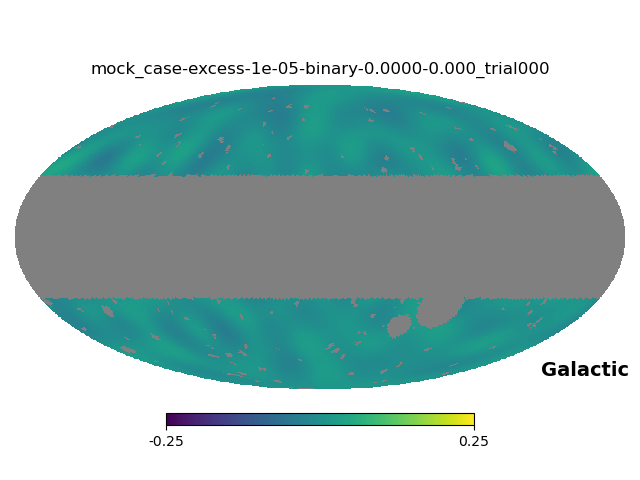

no files found for Lambda=1.0e-03
no files found for Lambda=1.0e-01


In [16]:
set_name = 'excess'
case_dict = dict(excess_mode='excess', selfunc_mode='binary', dipamp=0., base_rate=0.)

im_fn = show_mock_pngs(set_name, trials=[0], **case_dict)

Cells_res_cutsky = gather_Cell_results(Lambdas, set_name, case_dict)
dipole_res_cutsky = gather_dipole_results(set_name, case_dict)

Text(0.5, 1.0, 'Recovered Cells, excess mocks')

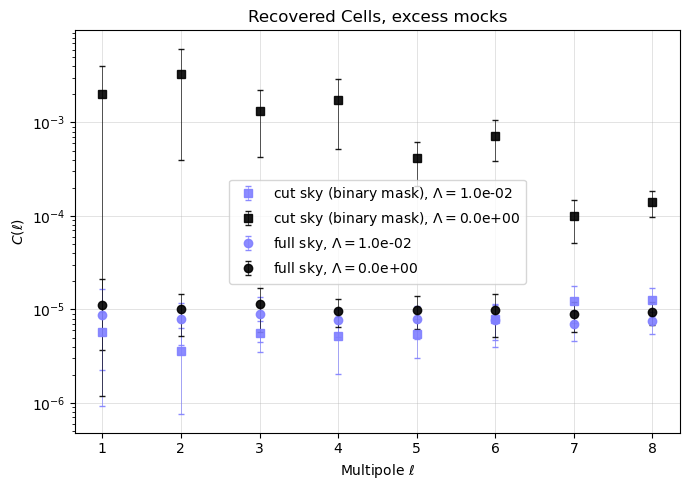

In [17]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

kwargs = dict(ls='None', capsize=2, lw=0.5, alpha=0.9)
for res_dict in Cells_res_cutsky[::-1]:
    Lambda = res_dict['Lambda']
    c = smap.to_rgba(Lambda) if Lambda != 0. else 'k'
    ax.errorbar(res_dict['ells'], res_dict['mean_Cells'], yerr=res_dict['std_Cells'], c=c, marker='s',
                label=r'cut sky (binary mask), $\Lambda=$'f'{Lambda:.1e}', **kwargs)

for res_dict in Cells_res[::-1]:
    Lambda = res_dict['Lambda']
    c = smap.to_rgba(Lambda) if Lambda != 0. else 'k'
    ax.errorbar(res_dict['ells'], res_dict['mean_Cells'], yerr=res_dict['std_Cells'], c=c, marker='o',
                label=r'full sky, $\Lambda=$'f'{Lambda:.1e}', **kwargs)


ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel('$C(\ell)$')
ax.legend()
ax.set_title(f'Recovered Cells, {set_name} mocks')

Again, we need to regularize when dealing with a cut sky—though it looks like for CatWISE, $\Lambda=10^{-2}$ over-regularizes.

#### Case 5. dipole on the full sky, _no_ shot noise

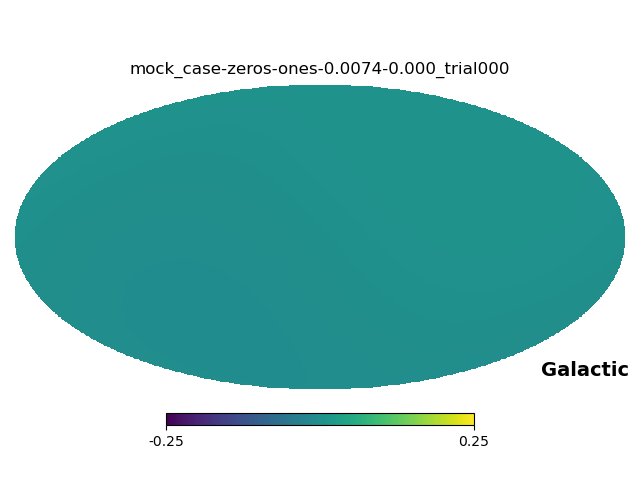

no files found for Lambda=1.0e-03
no files found for Lambda=1.0e-01


In [18]:
set_name = 'ideal_catwise'
case_dict = dict(excess_mode='zeros', selfunc_mode='ones', dipamp=0.0074, base_rate=0.)

im_fn = show_mock_pngs(set_name, trials=[0], **case_dict)

Cells_res = gather_Cell_results(Lambdas, set_name, case_dict)
dipole_res = gather_dipole_results(set_name, case_dict)

Text(0.5, 1.0, 'Recovered Cells, ideal_catwise mocks')

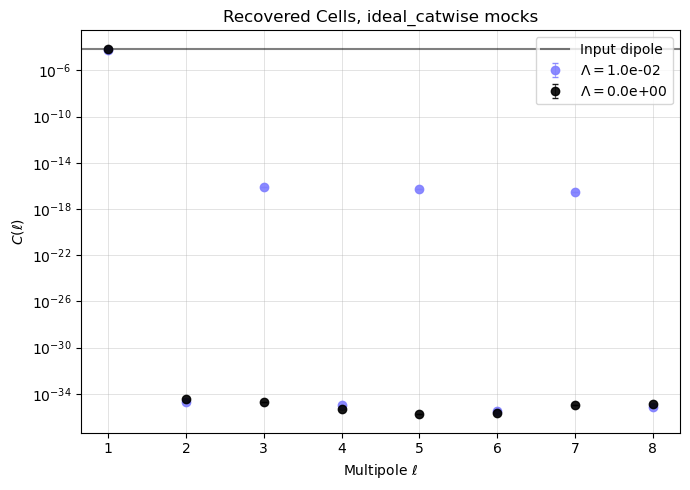

In [19]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

kwargs = dict(marker='o', ls='None', capsize=2, lw=0.5, alpha=0.9)
for res_dict in Cells_res[::-1]:
    Lambda = res_dict['Lambda']
    c = smap.to_rgba(Lambda) if Lambda != 0. else 'k'
    ax.errorbar(res_dict['ells'], res_dict['mean_Cells'], yerr=res_dict['std_Cells'], c=c,
                label='$\Lambda=$'f'{Lambda:.1e}', **kwargs)

# input dipole amplitude in C_1
ax.axhline(tools.C1_from_D(case_dict['dipamp']), c='k', alpha=0.5, label='Input dipole')
ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel('$C(\ell)$')
ax.legend()
ax.set_title(f'Recovered Cells, {set_name} mocks')

#### Case 6. dipole on the cut sky, _no_ shot noise

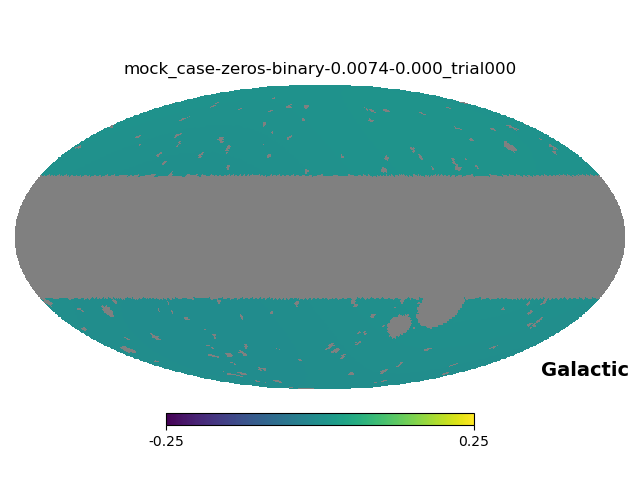

no files found for Lambda=1.0e-03
no files found for Lambda=1.0e-01


In [20]:
set_name = 'binary_catwise'
case_dict = dict(excess_mode='zeros', selfunc_mode='binary', dipamp=0.0074, base_rate=0.)

im_fn = show_mock_pngs(set_name, trials=[0], **case_dict)

Cells_res_cutsky = gather_Cell_results(Lambdas, set_name, case_dict)
dipole_res_cutsky = gather_dipole_results(set_name, case_dict)

Text(0.5, 1.0, 'Recovered Cells, binary_catwise mocks')

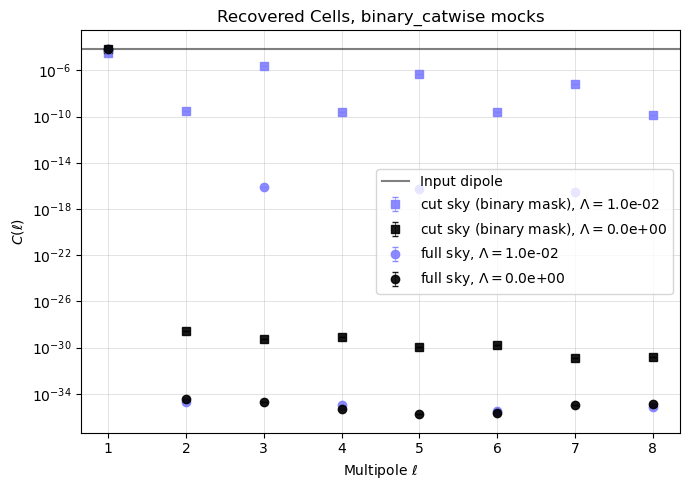

In [21]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

kwargs = dict(ls='None', capsize=2, lw=0.5, alpha=0.9)
for res_dict in Cells_res_cutsky[::-1]:
    Lambda = res_dict['Lambda']
    c = smap.to_rgba(Lambda) if Lambda != 0. else 'k'
    ax.errorbar(res_dict['ells'], res_dict['mean_Cells'], yerr=res_dict['std_Cells'], c=c, marker='s',
                label=r'cut sky (binary mask), $\Lambda=$'f'{Lambda:.1e}', **kwargs)
for res_dict in Cells_res[::-1]:
    Lambda = res_dict['Lambda']
    c = smap.to_rgba(Lambda) if Lambda != 0. else 'k'
    ax.errorbar(res_dict['ells'], res_dict['mean_Cells'], yerr=res_dict['std_Cells'], c=c, marker='o',
                label=r'full sky, $\Lambda=$'f'{Lambda:.1e}', **kwargs)

# input dipole amplitude in C_1
ax.axhline(tools.C1_from_D(case_dict['dipamp']), c='k', alpha=0.5, label='Input dipole')
ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel('$C(\ell)$')
ax.legend()
ax.set_title(f'Recovered Cells, {set_name} mocks')

#### Case 7. dipole on the full sky, shot noise, but no "excess" power

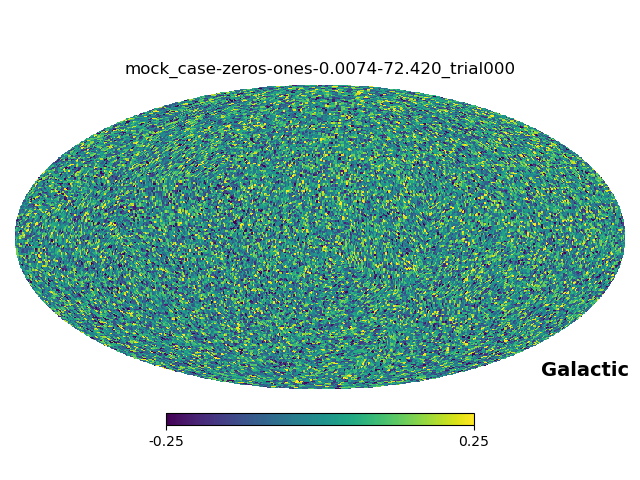

no files found for Lambda=1.0e-03
no files found for Lambda=1.0e-01


In [22]:
set_name = 'ideal_catwise'
case_dict = dict(excess_mode='zeros', selfunc_mode='ones', dipamp=0.0074, base_rate=72.42)

im_fn = show_mock_pngs(set_name, trials=[0], **case_dict)

Cells_res = gather_Cell_results(Lambdas, set_name, case_dict)
dipole_res = gather_dipole_results(set_name, case_dict)

Text(0.5, 1.0, 'Recovered Cells, ideal_catwise mocks')

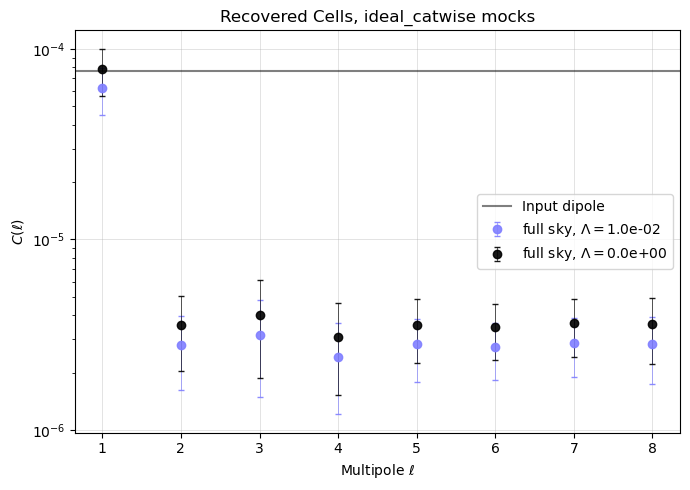

In [23]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

kwargs = dict(marker='o', ls='None', capsize=2, lw=0.5, alpha=0.9)
for res_dict in Cells_res[::-1]:
    Lambda = res_dict['Lambda']
    c = smap.to_rgba(Lambda) if Lambda != 0. else 'k'
    ax.errorbar(res_dict['ells'], res_dict['mean_Cells'], yerr=res_dict['std_Cells'], c=c,
                label=r'full sky, $\Lambda=$'f'{Lambda:.1e}', **kwargs)

# input dipole amplitude in C_1
ax.axhline(tools.C1_from_D(case_dict['dipamp']), c='k', alpha=0.5, label='Input dipole')
ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel('$C(\ell)$')
ax.legend()
ax.set_title(f'Recovered Cells, {set_name} mocks')

#### Case 8. dipole on the cut sky, shot noise, but no "excess" power

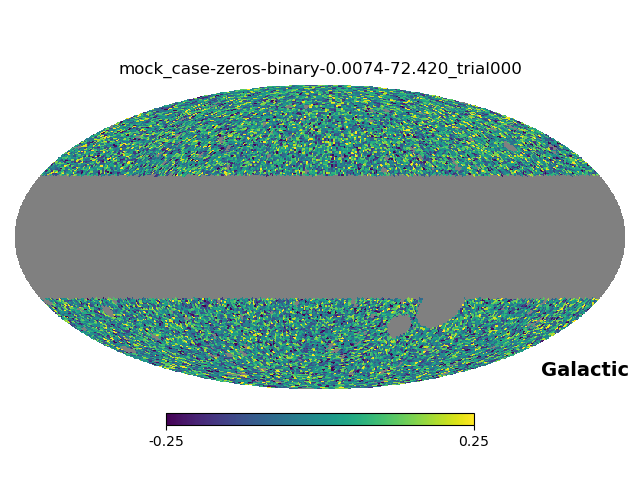

no files found for Lambda=1.0e-03


In [24]:
set_name = 'binary_catwise'
case_dict = dict(excess_mode='zeros', selfunc_mode='binary', dipamp=0.0074, base_rate=72.42)

im_fn = show_mock_pngs(set_name, trials=[0], **case_dict)

Cells_res_cutsky = gather_Cell_results(Lambdas, set_name, case_dict)
dipole_res_cutsky = gather_dipole_results(set_name, case_dict)

Text(0.5, 1.0, 'Recovered Cells, binary_catwise mocks')

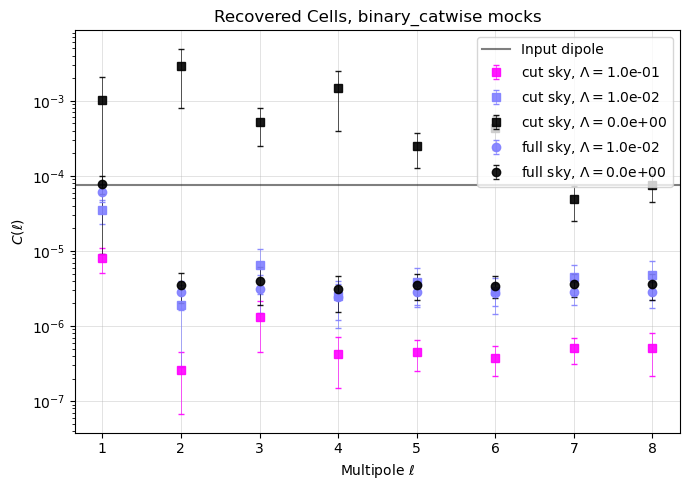

In [25]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

kwargs = dict(ls='None', capsize=2, lw=0.5, alpha=0.9)
for res_dict in Cells_res_cutsky[::-1]:
    Lambda = res_dict['Lambda']
    c = smap.to_rgba(Lambda) if Lambda != 0. else 'k'
    ax.errorbar(res_dict['ells'], res_dict['mean_Cells'], yerr=res_dict['std_Cells'], c=c, marker='s',
                label=r'cut sky, $\Lambda=$'f'{Lambda:.1e}', **kwargs)
for res_dict in Cells_res[::-1]:
    Lambda = res_dict['Lambda']
    c = smap.to_rgba(Lambda) if Lambda != 0. else 'k'
    ax.errorbar(res_dict['ells'], res_dict['mean_Cells'], yerr=res_dict['std_Cells'], c=c, marker='o',
                label=r'full sky, $\Lambda=$'f'{Lambda:.1e}', **kwargs)

# input dipole amplitude in C_1
ax.axhline(tools.C1_from_D(case_dict['dipamp']), c='k', alpha=0.5, label='Input dipole')
ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel('$C(\ell)$')
ax.legend()
ax.set_title(f'Recovered Cells, {set_name} mocks')

#### Case 9. dipole on the full sky, plus shot noise, plus excess power (1e-5)

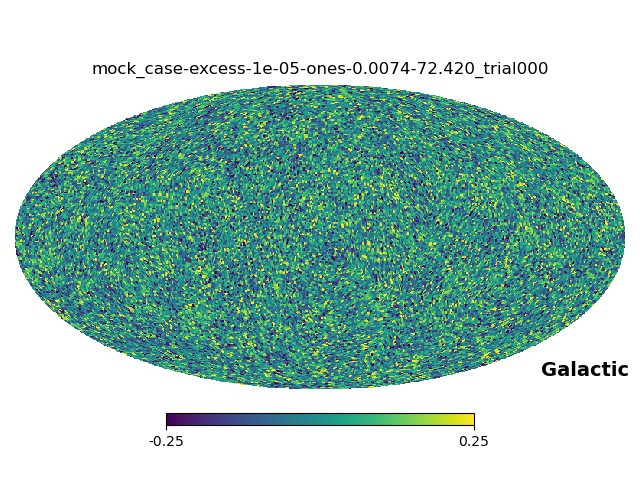

no files found for Lambda=1.0e-03
no files found for Lambda=1.0e-01


In [27]:
set_name = 'excess_catwise'
case_dict = dict(excess_mode='excess-1e-05', selfunc_mode='ones', dipamp=0.0074, base_rate=72.42)

im_fn = show_mock_pngs(set_name, trials=[0], **case_dict)

Cells_res = gather_Cell_results(Lambdas, set_name, case_dict)
dipole_res = gather_dipole_results(set_name, case_dict)

Text(0.5, 1.0, 'Recovered Cells, excess_catwise mocks')

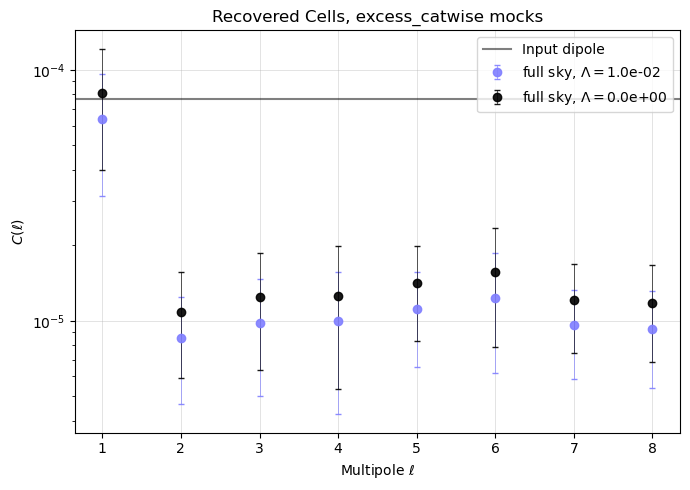

In [28]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

kwargs = dict(marker='o', ls='None', capsize=2, lw=0.5, alpha=0.9)
for res_dict in Cells_res[::-1]:
    Lambda = res_dict['Lambda']
    c = smap.to_rgba(Lambda) if Lambda != 0. else 'k'
    ax.errorbar(res_dict['ells'], res_dict['mean_Cells'], yerr=res_dict['std_Cells'], c=c,
                label=r'full sky, $\Lambda=$'f'{Lambda:.1e}', **kwargs)

# input dipole amplitude in C_1
ax.axhline(tools.C1_from_D(case_dict['dipamp']), c='k', alpha=0.5, label='Input dipole')
ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel('$C(\ell)$')
ax.legend()
ax.set_title(f'Recovered Cells, {set_name} mocks')

#### Case 10. dipole on the cut sky, plus shot noise, plus excess power (1e-5)

In [ ]:
set_name = 'excess_catwise'
case_dict = dict(excess_mode='excess-1e-05', selfunc_mode='binary', dipamp=0.0074, base_rate=72.42)

im_fn = show_mock_pngs(set_name, trials=[0], **case_dict)

Cells_res_cutsky = gather_Cell_results(Lambdas, set_name, case_dict)
dipole_res_cutsky = gather_dipole_results(set_name, case_dict)

### realistic case, CatWISE

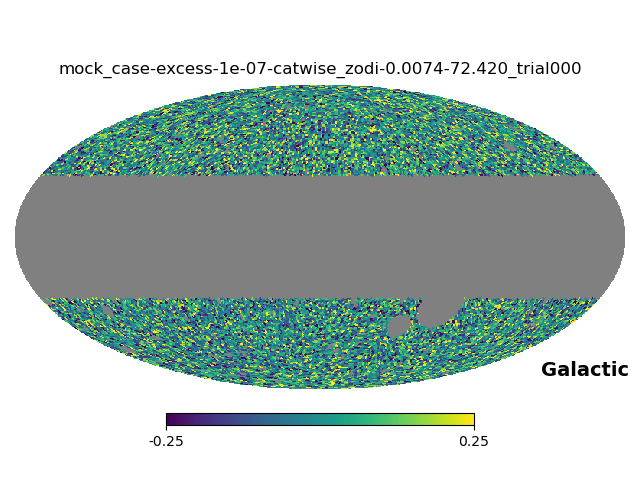

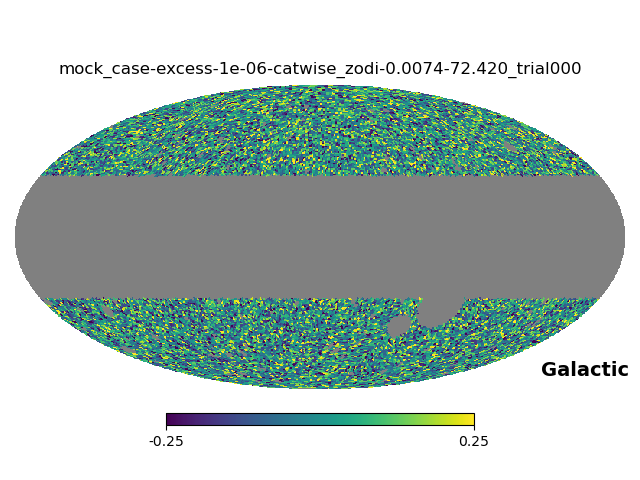

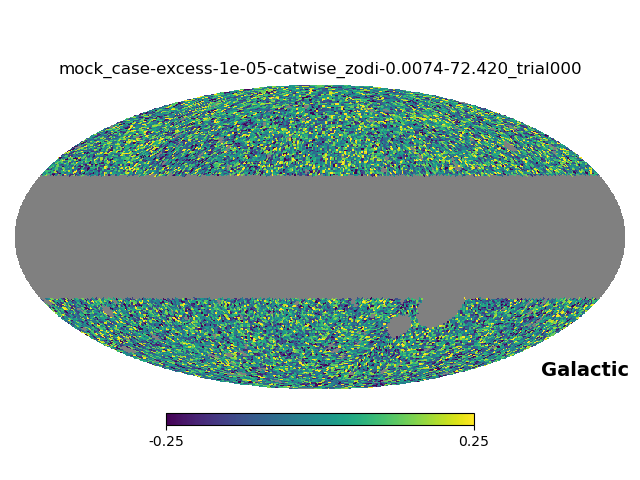

In [88]:
# mocks
set_name = 'excess_catwise'
Lambda = 1e-3
excesss = [1e-7, 1e-6, 1e-5]
Cells_mocks = []
for i, excess in enumerate(excesss):
    case_dict = dict(excess_mode=f'excess-{excess:.0e}', selfunc_mode='catwise_zodi', dipamp=0.0074, base_rate=72.42)
    im_fn = show_mock_pngs(set_name, trials=[0], **case_dict)

    Cells_res = gather_Cell_results([Lambda], set_name, case_dict)
    Cells_mocks.append(Cells_res[0])

In [89]:
# shot noise
case_dict_shot_noise = dict(excess_mode='zeros', selfunc_mode='ones', dipamp=0., base_rate=72.42)
Cells_shot_noise = gather_Cell_results([Lambda], 'shot_noise_catwise', case_dict_shot_noise)[0]

In [90]:
# data
fn_data = os.path.join('/scratch/aew492/lss-dipoles_results/results/results_data',
                    f"Cells_Lambda-{Lambda:.1e}_catwise_case-catwise_zodi.npy")
data_dict = np.load(fn_data, allow_pickle=True).item()
ells_data = data_dict['ells'][1:]
Cells_data = data_dict['Cells'][1:]
print(data_dict['Lambda'])

# and dipole
fn_data = os.path.join('/scratch/aew492/lss-dipoles_results/results/results_data',
                    f"dipole_comps_Lambdas_catwise_case-catwise_zodi.npy")
data_dict = np.load(fn_data, allow_pickle=True).item()
Lambdas = data_dict['Lambdas']
dipole_amps = np.linalg.norm(data_dict['dipole_comps'], axis=1)

0.001


Text(0, 0.5, 'Dipole amplitude')

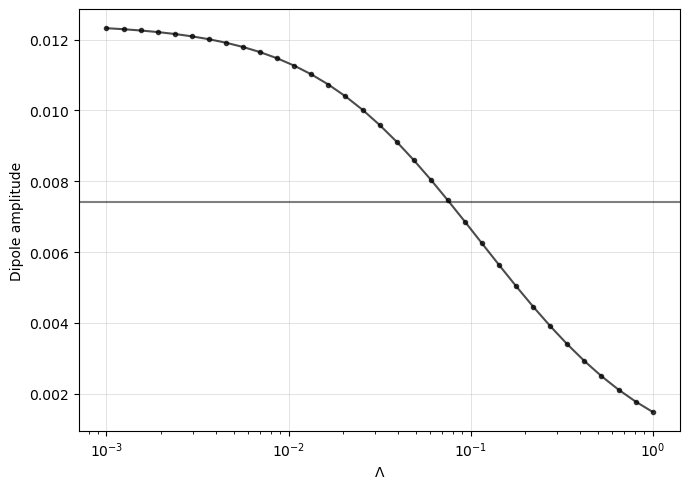

In [91]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.plot(Lambdas, dipole_amps, 'k.-', alpha=0.7)
ax.axhline(case_dict['dipamp'], c='k', alpha=0.5, label='Expected')
ax.semilogx()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'$\Lambda$')
ax.set_ylabel('Dipole amplitude')

Text(0.5, 1.0, 'Recovered Cells, excess_catwise mocks, $\\Lambda=$1e-03')

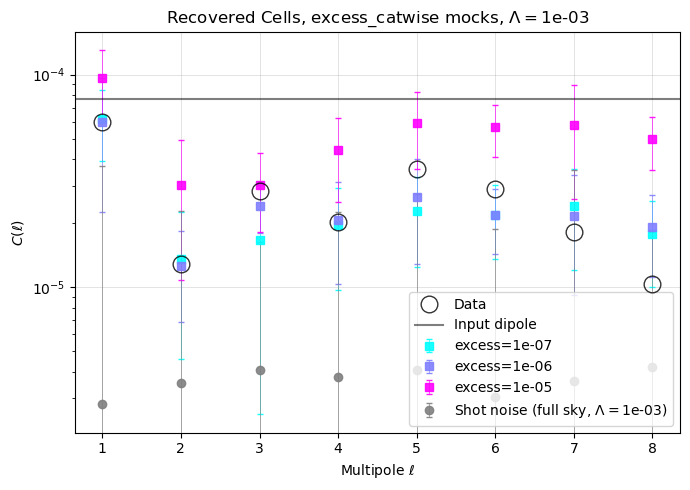

In [92]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
norm_excess = mpl.colors.LogNorm(vmin=min(excesss), vmax=max(excesss))
smap_excess = mpl.cm.ScalarMappable(norm=norm_excess, cmap='cool')

kwargs = dict(ls='None', capsize=2, lw=0.5, alpha=0.9)
for i, res_dict in enumerate(Cells_mocks):
    Lambda = res_dict['Lambda']
    ax.errorbar(res_dict['ells'], res_dict['mean_Cells'], yerr=res_dict['std_Cells'], c=smap_excess.to_rgba(excesss[i]),
                label=f'excess={excesss[i]:.0e}', marker='s', **kwargs)
# shot noise
ax.errorbar(Cells_shot_noise['ells'], Cells_shot_noise['mean_Cells'], yerr=res_dict['std_Cells'], c='grey',
            label='Shot noise (full sky, 'r'$\Lambda=$'f'{Lambda:.0e})', marker='o', **kwargs)

# data
ax.plot(ells_data, Cells_data, c='None', mec='k', ms=12, marker='o', ls='None', alpha=0.8,
            label='Data', zorder=99)

# input dipole amplitude in C_1
ax.axhline(tools.C1_from_D(case_dict['dipamp']), c='k', alpha=0.5, label='Input dipole')
ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel('$C(\ell)$')
ax.legend()
ax.set_title(f'Recovered Cells, {set_name} mocks, 'r'$\Lambda=$'f'{Lambda:.0e}')

### realistic case, Quaia

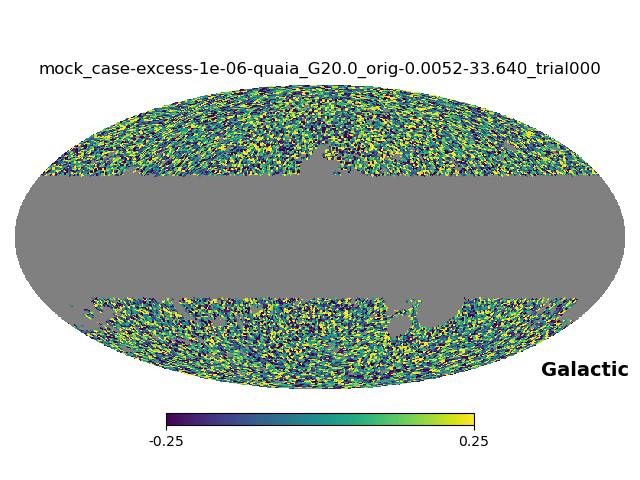

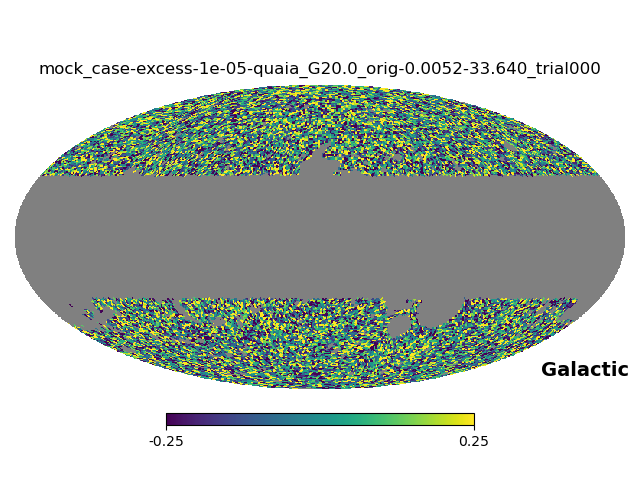

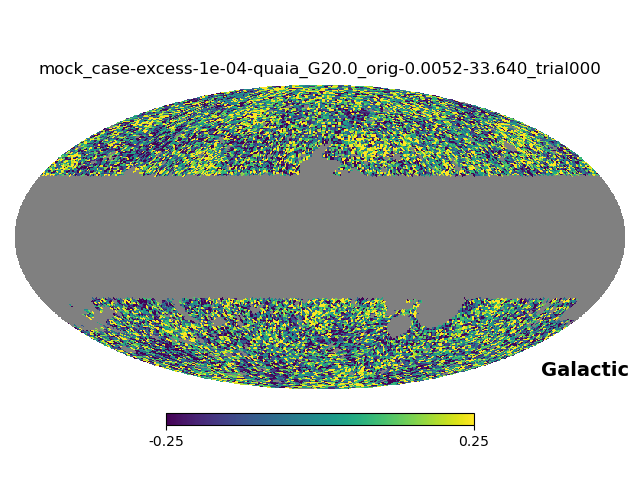

In [76]:
# mocks
set_name = 'excess_quaia'
Lambda = 1e-2
excesss = [1e-6, 1e-5, 1e-4]
Cells_mocks = []
for i, excess in enumerate(excesss):
    case_dict = dict(excess_mode=f'excess-{excess:.0e}', selfunc_mode='quaia_G20.0_orig', dipamp=0.0052, base_rate=33.64)
    im_fn = show_mock_pngs(set_name, trials=[0], **case_dict)

    Cells_res = gather_Cell_results([Lambda], set_name, case_dict)
    Cells_mocks.append(Cells_res[0])

In [77]:
# shot noise
case_dict_shot_noise = dict(excess_mode='zeros', selfunc_mode='ones', dipamp=0., base_rate=33.64)
Cells_shot_noise = gather_Cell_results([Lambda], 'shot_noise_quaia', case_dict_shot_noise)[0]

In [79]:
# data
fn_data = os.path.join('/scratch/aew492/lss-dipoles_results/results/results_data',
                    f"Cells_Lambda-{Lambda:.1e}_quaia_G20.0_case-quaia_G20.0_orig.npy")
data_dict = np.load(fn_data, allow_pickle=True).item()
ells_data = data_dict['ells'][1:]
Cells_data = data_dict['Cells'][1:]
print(data_dict['Lambda'])

# and dipole
fn_data = os.path.join('/scratch/aew492/lss-dipoles_results/results/results_data',
                    f"dipole_comps_Lambdas_quaia_G20.0_case-quaia_G20.0_orig.npy")
data_dict = np.load(fn_data, allow_pickle=True).item()
Lambdas = data_dict['Lambdas']
dipole_amps = np.linalg.norm(data_dict['dipole_comps'], axis=1)

0.01


Text(0, 0.5, 'Dipole amplitude')

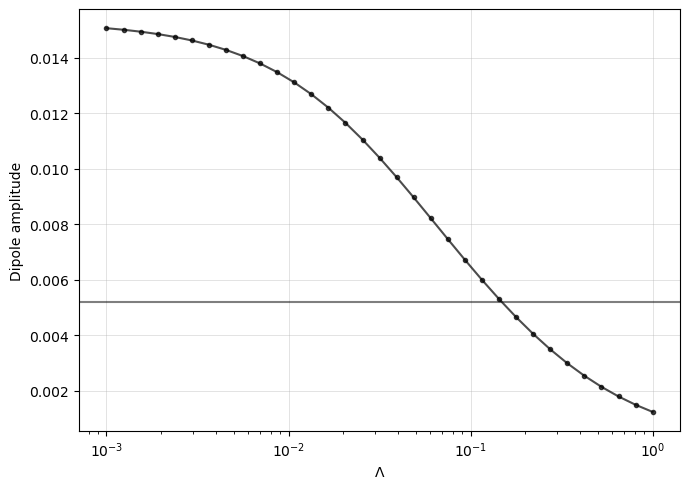

In [80]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.plot(Lambdas, dipole_amps, 'k.-', alpha=0.7)
ax.axhline(case_dict['dipamp'], c='k', alpha=0.5, label='Expected')
ax.semilogx()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'$\Lambda$')
ax.set_ylabel('Dipole amplitude')

Text(0.5, 1.0, 'Recovered Cells, excess_quaia mocks, $\\Lambda=$1e-02')

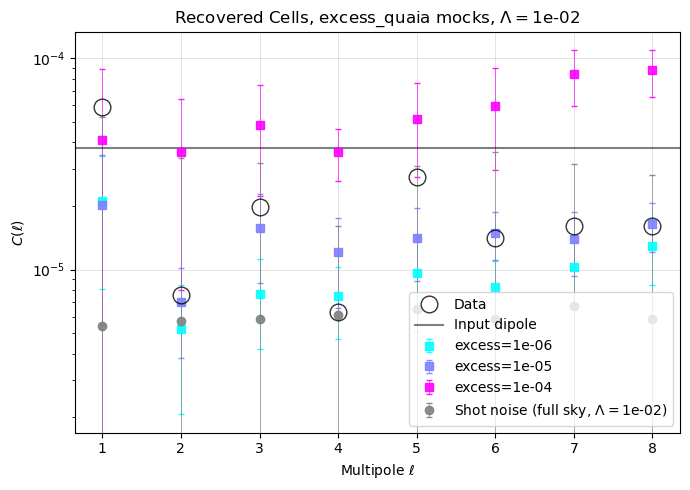

In [81]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
norm_excess = mpl.colors.LogNorm(vmin=min(excesss), vmax=max(excesss))
smap_excess = mpl.cm.ScalarMappable(norm=norm_excess, cmap='cool')

kwargs = dict(ls='None', capsize=2, lw=0.5, alpha=0.9)
for i, res_dict in enumerate(Cells_mocks):
    Lambda = res_dict['Lambda']
    ax.errorbar(res_dict['ells'], res_dict['mean_Cells'], yerr=res_dict['std_Cells'], c=smap_excess.to_rgba(excesss[i]),
                label=f'excess={excesss[i]:.0e}', marker='s', **kwargs)
# shot noise
ax.errorbar(Cells_shot_noise['ells'], Cells_shot_noise['mean_Cells'], yerr=res_dict['std_Cells'], c='grey',
            label='Shot noise (full sky, 'r'$\Lambda=$'f'{Lambda:.0e})', marker='o', **kwargs)

# data
ax.plot(ells_data, Cells_data, c='None', mec='k', ms=12, marker='o', ls='None', alpha=0.8,
            label='Data', zorder=99)

# input dipole amplitude in C_1
ax.axhline(tools.C1_from_D(case_dict['dipamp']), c='k', alpha=0.5, label='Input dipole')
ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel('$C(\ell)$')
ax.legend()
ax.set_title(f'Recovered Cells, {set_name} mocks, 'r'$\Lambda=$'f'{Lambda:.0e}')